In [ ]:
# import
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add this optional print to confirm
print("Using device:", device)

Using device: cpu


In [ ]:
# Define hyperparameters
nu = 0.01           # Viscosity coefficient that controls the strength of diffusion
N_f = 10000         # Number of collocation points used to enforce the PDE residual
N_u = 100           # Number of points used for initial and boundary conditions

In [ ]:
# Define neural networks
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(2, 50), # Input (x,t) → 50 dimentions
            nn.Tanh(), # Activation Function
            
            nn.Linear(50,50), # First hidden layer
            nn.Tanh(),
            
            nn.Linear(50, 50), # Second hidden layer
            nn.Tanh(),
            
            nn.Linear(50, 1) # Output
        )
    
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)  # Concatenate inputs x and t along the column (feature) dimension
        return self.net(xt)            # Perform forward pass through the network


In [ ]:
# Create training data (initial condition, boundary condition, and collocation points)
def get_training_data():
    # Initial condition
    x_ic = np.random.uniform(-1, 1, (N_u, 1))  # Randomly sample N_u x-values in [-1, 1]
    t_ic = np.zeros((N_u, 1))                 # Corresponding time values are all zero (t = 0)
    u_ic = -np.sin(np.pi * x_ic)              # Compute the initial wave: u(x,0) = -sin(πx)
    
    # Boundary condition
    t_bc = np.random.uniform(0, 1, (N_u // 2, 1))  # Random time values in [0, 1]
    x_bc_left = -np.ones((N_u // 2, 1))            # Left boundary: x = -1
    x_bc_right = np.ones((N_u // 2, 1))            # Right boundary: x = 1
    u_bc_left = np.zeros_like(x_bc_left)           # u = 0 at both boundaries
    u_bc_right = np.zeros_like(x_bc_right)
    
    # Combine boundary data
    x_bc = np.vstack([x_bc_left, x_bc_right])      # Stack left and right x-values vertically
    t_bc = np.vstack([t_bc, t_bc])                 # Duplicate t_bc to match left and right
    u_bc = np.vstack([u_bc_left, u_bc_right])      # Stack left and right u-values
    
    # Collocation points (used to enforce the PDE)
    x_f = np.random.uniform(-1, 1, (N_f, 1))
    t_f = np.random.uniform(0, 1, (N_f, 1))
    
    return x_ic, t_ic, u_ic, x_bc, t_bc, u_bc, x_f, t_f

In [38]:
# Create the model and convert the data to PyTorch tensors
model = PINN().to(device) # create the model and move it to the selected device

x_ic, t_ic, u_ic, x_bc, t_bc, u_bc, x_f, t_f = get_training_data()

# Convert the data to Torch tensors
x_ic = torch.tensor(x_ic, dtype=torch.float32).to(device) # shape: [N_u, 1]
t_ic = torch.tensor(t_ic, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic, dtype=torch.float32).to(device)

x_bc = torch.tensor(x_bc, dtype=torch.float32).to(device)
t_bc = torch.tensor(t_bc, dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)

# Convert cvollocation points
x_f = torch.tensor(x_f, dtype=torch.float32, requires_grad=True).to(device)
t_f = torch.tensor(t_f, dtype=torch.float32, requires_grad=True).to(device)

In [39]:
# Define the loss function for training the PINN
def pinn_loss(model):
    # IC loss
    u_pred_ic = model(x_ic, t_ic) # predict u at t=0
    loss_ic = torch.mean((u_pred_ic-u_ic)**2)
    
    # BC loss
    u_pred_bc = model(x_bc, t_bc) # predict u at x=-1,1
    loss_bc = torch.mean((u_pred_bc-u_bc)**2)
    
    # PDE Residual Loss
    u = model(x_f, t_f) # predict u at the collocation points
    
    # Compute partial derivatives using autograd
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]   # ∂u/∂x
    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]   # ∂u/∂t
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]  # ∂²u/∂x²

    # Compute the PDE residual: f = ∂u/∂t + u ∂u/∂x - ν ∂²u/∂x²
    f = u_t + u * u_x - nu * u_xx
    
    # Minimize the mean squared residual
    loss_f = torch.mean(f**2)
    
    # Total loss: initial + boundary + PDE
    return loss_ic + loss_bc + loss_f


In [40]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Set up a optimizer

# Run the training loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss = pinn_loss(model)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch{epoch}: Loss = {loss.item():.5f}")
    

Epoch0: Loss = 0.47801
Epoch500: Loss = 0.05510
Epoch1000: Loss = 0.01292
Epoch1500: Loss = 0.00873
Epoch2000: Loss = 0.00501
Epoch2500: Loss = 0.00337
Epoch3000: Loss = 0.00245
Epoch3500: Loss = 0.00190
Epoch4000: Loss = 0.00143
Epoch4500: Loss = 0.00116


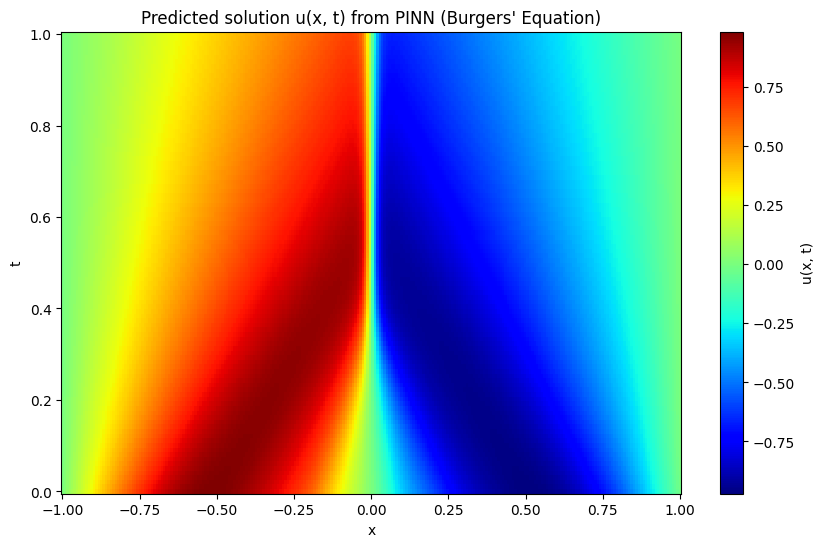

In [41]:
# Generate a grid of x and t values for evaluation
x = np.linspace(-1, 1, 256)       # 256 spatial points from -1 to 1
t = np.linspace(0, 1, 100)        # 100 time points from 0 to 1
X, T = np.meshgrid(x, t)          # Create a full grid of (x, t) pairs

# Flatten the grid and stack into [x, t] input shape for the model
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # shape: [25600, 2]
XT_torch = torch.tensor(XT, dtype=torch.float32).to(device)   # Convert to torch tensor

# Predict u(x, t) for the entire grid
with torch.no_grad():  # No need to track gradients here
    u_pred = model(XT_torch[:, 0:1], XT_torch[:, 1:2]).cpu().numpy()  # shape: [25600, 1]
    u_pred = u_pred.reshape(100, 256)  # Reshape to [t, x] shape for plotting

# Plot the predicted u(x, t) as a heatmap
plt.figure(figsize=(10, 6))
plt.pcolormesh(X, T, u_pred, shading='auto', cmap='jet')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution u(x, t) from PINN (Burgers\' Equation)')
plt.show()

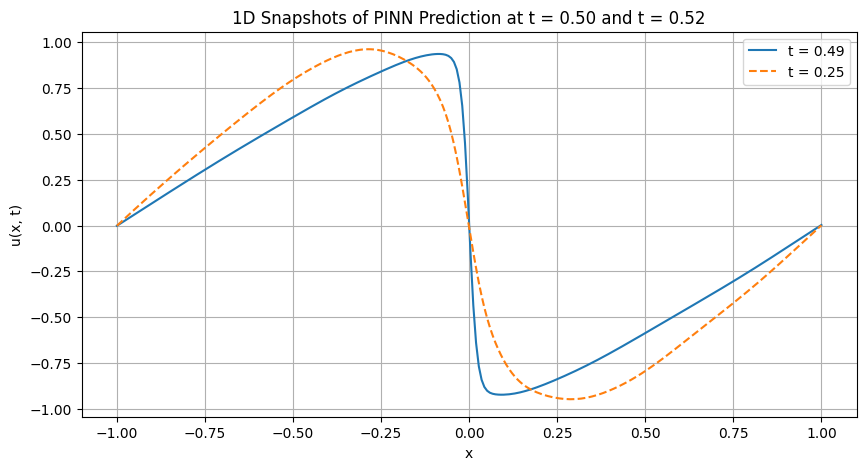

In [43]:
# Plotting 1D snapshots of u
u_pred.shape = [100, 256]  # [time, space]

# Reuse the same x grid (from before)
x = np.linspace(-1, 1, 256)

# Step size in t-axis
t_step = 1.0 / 99  # because you sampled 100 points from 0 to 1 (inclusive)

# Find the closest index to t=0.5 and t=0.25
idx_050 = np.argmin(np.abs(t - 0.50))
idx_052 = np.argmin(np.abs(t - 0.25))

# Plot both
plt.figure(figsize=(10, 5))
plt.plot(x, u_pred[idx_050], label=f't = {t[idx_050]:.2f}')
plt.plot(x, u_pred[idx_052], label=f't = {t[idx_052]:.2f}', linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('1D Snapshots of PINN Prediction at t = 0.50 and t = 0.52')
plt.legend()
plt.grid(True)
plt.show()
